[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mifumo081a/pytorch_template/blob/main/examples/notebooks/mnist.ipynb)


In [23]:
!git clone https://github.com/mifumo081a/pytorch_template.git
!ls

fatal: destination path 'pytorch_template' already exists and is not an empty directory.
data  kfold_pickle  logs  models  pytorch_template  sample_data


In [24]:
!pip install -r pytorch_template/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
import os
import torchinfo

In [26]:
root = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN =True

In [27]:
logs_root = os.path.join(root, "logs/", "mnist/")
os.makedirs(logs_root, exist_ok=True)

In [28]:
trainval_dataset = datasets.MNIST(os.path.join(root, "data/"), train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(os.path.join(root, "data/"), train=False, download=True, transform=transforms.ToTensor())

trainval_dataset.labels = [str(i) for i in range(10)]
test_dataset.labels  = [str(i) for i in range(10)]

transforms_dict = {"train": 
                   transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "val":
                    transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "test":
                   transforms.Compose([
                       transforms.ToTensor()
                       ])
}

In [29]:
import pytorch_template.cross_varidation as cv

In [30]:
num_workers = os.cpu_count()
n_splits = 5
batch_size = 50
if TRAIN:
    kfold_root = cv.kfold_split(dataset=trainval_dataset, test_dataset=test_dataset, transforms=transforms_dict, n_splits=n_splits,
                                root=root, num_workers=num_workers, batch_size=batch_size,
                                shuffle=True, random_state=0)
else:
    os.path.join(root, "kfold_pickle")
print(kfold_root)

Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Test: 10000
All: 70000
/content/kfold_pickle


# Model initialize and Train

In [31]:
from pytorch_template.models import *

In [32]:
class Model(GradCAM_Model):
    def __init__(self):
        super().__init__()
        self.features = torchvision.models.vgg16(pretrained=True).features[:10]
        for layer in self.features:
            for param in layer.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def get_fmaps_alpha(self, x):
        fmaps = self.get_features(x)
        fmaps = fmaps.clone().detach().requires_grad_(True)
        outputs = self.get_outputs(fmaps)
        pred_idx = torch.argmax(outputs)
        outputs[:, pred_idx].backward()
        alpha = fmaps.grad.mean([-2, -1])
        
        return fmaps, alpha

    def get_cam(self, x):
        fmaps, alpha = self.get_fmaps_alpha(x)
        feature_num, cls_num = alpha.shape[1], alpha.shape[0]
        cam_mapper = nn.Conv2d(feature_num, cls_num, kernel_size=1, padding=0, bias=False)
        cam_mapper.weight = nn.Parameter(alpha.unsqueeze(-1).unsqueeze(-1))
        
        with torch.no_grad():
            cam = cam_mapper(fmaps)
            cam = F.relu(cam)
        
        return cam
        
    def get_features(self, x):
        x = x.repeat(1, 3, 1, 1)
        return self.features(x)
    
    def get_outputs(self, x):
        x = x.mean([2, 3])
        return self.classifier(x)
        
    def forward(self,x):
        x = self.get_features(x)
        x = self.get_outputs(x)
        return x

torchinfo.summary(Model(), (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           (1,792)
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           (36,928)
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-10                   [1, 128, 7, 7]            --
├─Sequential: 1-2                        [1, 10]             

In [33]:
from pytorch_template.utils import get_dataloaders, get_testloaders, get_model, set_model
from pytorch_template.trainer import Trainer_Classifier

In [34]:
model_root = os.path.join(root, "models/")
print(model_root)
if TRAIN:
    set_model(model=Model(), model_root=model_root)

/content/models/


In [35]:
if TRAIN:
  trainer_list = []
  for k in range(n_splits):
    path = os.path.join(kfold_root, str(k)+"/")
    print(path)
    trainer = Trainer_Classifier(model=get_model("nontrain", model_root, device),
                                 device=device, dataloaders=get_dataloaders(path),
                                 epochs=10, lr=1e-3)
    trainer_list.append(trainer)

/content/kfold_pickle/0/
/content/models/nontrain.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/1/
/content/models/nontrain.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/2/
/content/models/nontrain.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/3/
/content/models/nontrain.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/4/
/content/models/nontrain.pkl
/content/kfold_pickle/4/dataloaders.pkl


In [36]:
if TRAIN:
    cv.kfold_train(save_model_root=model_root, n_splits=n_splits,
                   trainer_list=trainer_list)

Pattern:  0


[Epoch2/2]: 100%|██████████| 2/2 [00:22<00:00, 11.40s/it, Loss=1.77, Acc=0.853]


Best val Loss: 1.7725
Acc: 0.8530 
Pattern:  1


[Epoch2/2]: 100%|██████████| 2/2 [00:18<00:00,  9.50s/it, Loss=1.77, Acc=0.845]


Best val Loss: 1.7744
Acc: 0.8445 
Pattern:  2


[Epoch2/2]: 100%|██████████| 2/2 [00:19<00:00,  9.57s/it, Loss=1.77, Acc=0.824]


Best val Loss: 1.7735
Acc: 0.8244 
Pattern:  3


[Epoch2/2]: 100%|██████████| 2/2 [00:19<00:00,  9.67s/it, Loss=1.77, Acc=0.846]


Best val Loss: 1.7749
Acc: 0.8456 
Pattern:  4


[Epoch2/2]: 100%|██████████| 2/2 [00:21<00:00, 10.54s/it, Loss=1.77, Acc=0.854]

Best val Loss: 1.7718
Acc: 0.8538 


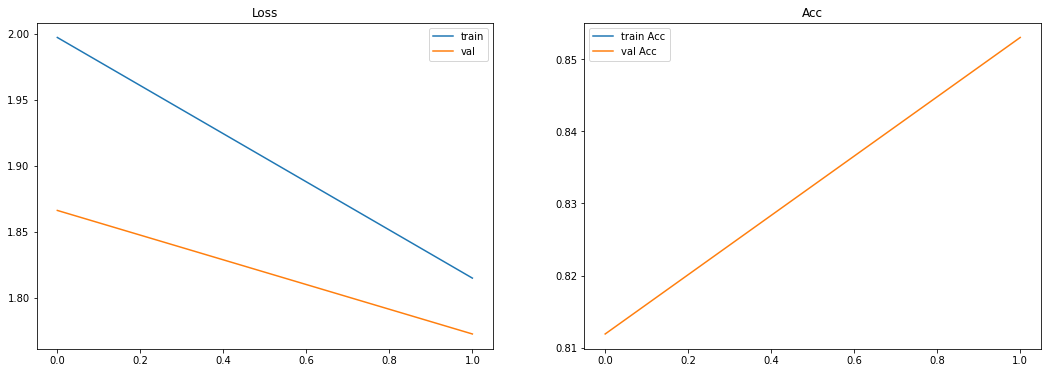

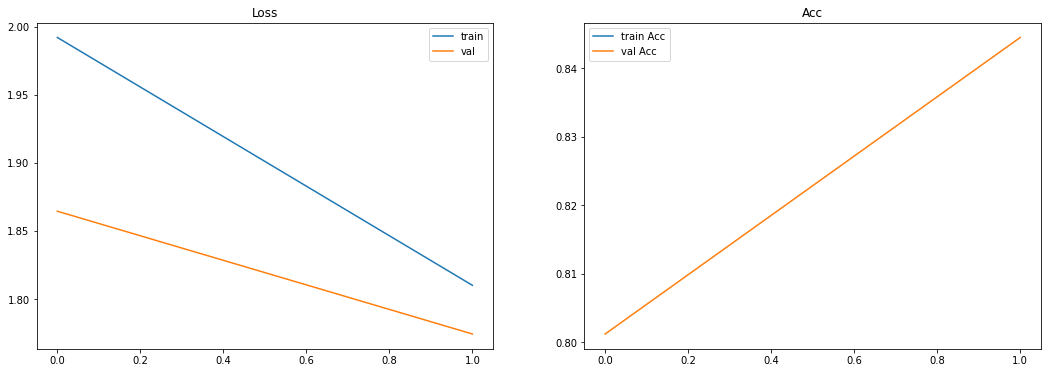

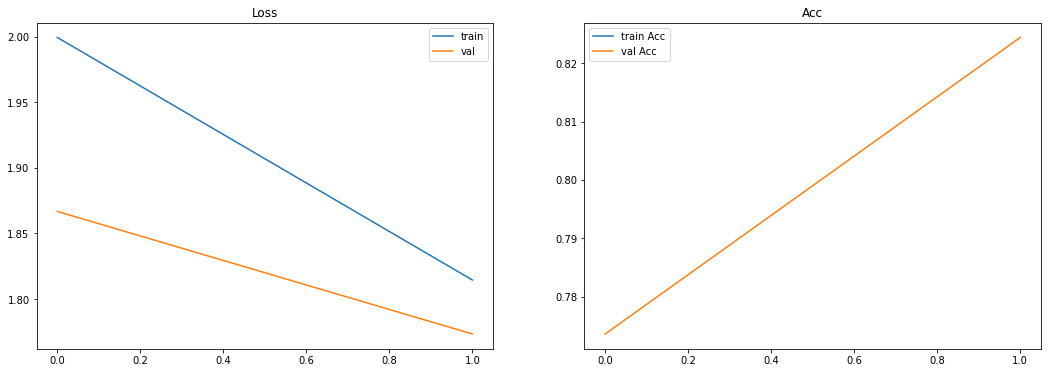

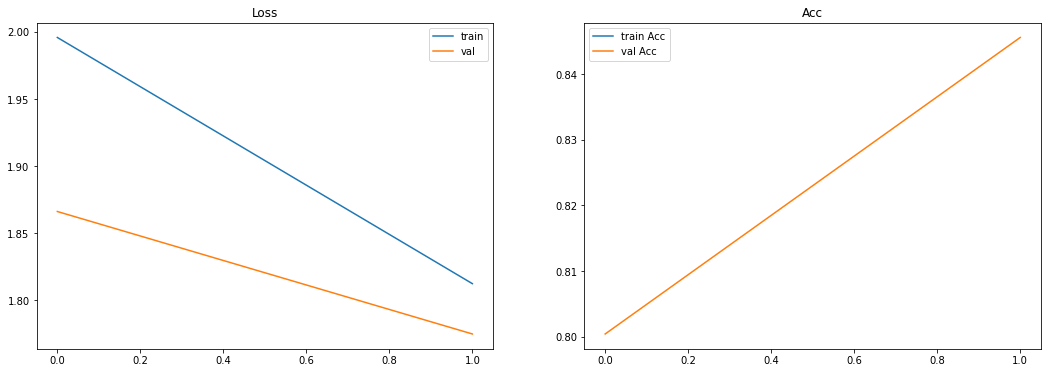

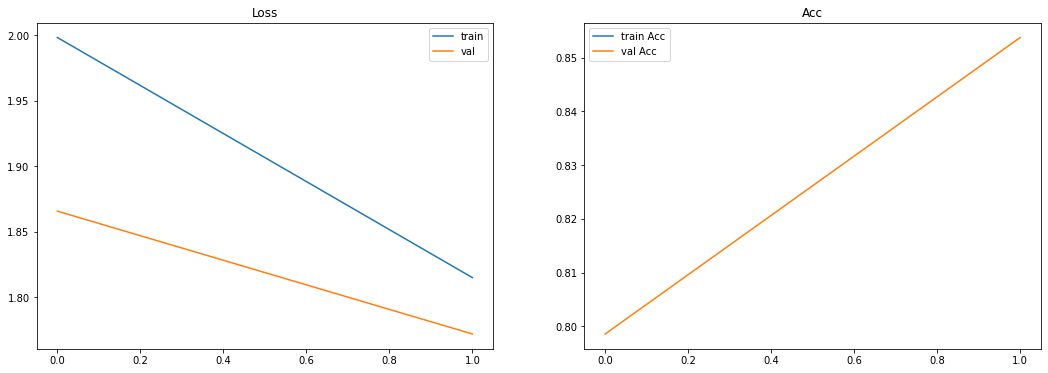

In [37]:
if TRAIN:
    for k in range(n_splits):
        path = os.path.join(kfold_root, str(k)+"/")
        trainer_list[k].show_curve(logs_root=os.path.join
                                   (logs_root, "curves/"), fname=str(k), save=False)

# Evaluate models

In [38]:
from pytorch_template.evaluator import ImageClassifier_Evaluator

In [39]:
evaluator_list = []
for k in range(n_splits):
    dataloader_path = os.path.join(kfold_root, str(k)+"/")
    model_path = os.path.join(model_root, str(k)+"/")
    print(dataloader_path, model_path)
    evaluator_list.append(ImageClassifier_Evaluator(model=get_model("model_fit", model_path, device),
                                          device=device,
                                          dataloaders=get_dataloaders(dataloader_path),
                                          testloaders=get_testloaders(kfold_root),
                                          logs_root=logs_root
                                         )
                         )

/content/kfold_pickle/0/ /content/models/0/
/content/models/0/model_fit.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/1/ /content/models/1/
/content/models/1/model_fit.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/2/ /content/models/2/
/content/models/2/model_fit.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/3/ /content/models/3/
/content/models/3/model_fit.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/4/ /content/models/4/
/content/models/4/model_fit.pkl
/content/kfold_pickle/4/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl


              precision    recall  f1-score   support

           0       0.85      0.92      0.89       980
           1       0.98      0.98      0.98      1135
           2       0.77      0.75      0.76      1032
           3       0.95      0.74      0.83      1010
           4       0.90      0.89      0.89       982
           5       0.64      0.88      0.74       892
           6       0.89      0.86      0.87       958
           7       0.91      0.84      0.88      1028
           8       0.91      0.88      0.90       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



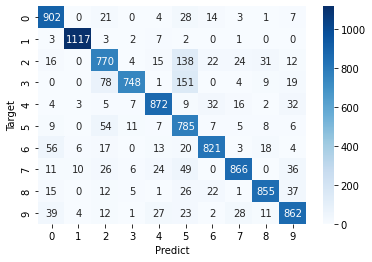

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       980
           1       0.98      0.99      0.98      1135
           2       0.68      0.82      0.74      1032
           3       0.95      0.73      0.83      1010
           4       0.85      0.92      0.88       982
           5       0.69      0.83      0.75       892
           6       0.95      0.81      0.87       958
           7       0.95      0.81      0.88      1028
           8       0.85      0.92      0.88       974
           9       0.86      0.86      0.86      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



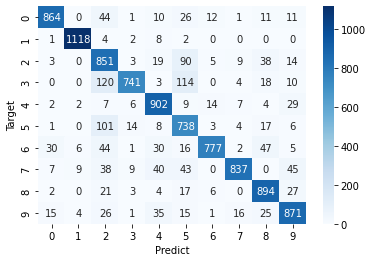

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       980
           1       0.98      0.98      0.98      1135
           2       0.54      0.90      0.67      1032
           3       0.97      0.62      0.76      1010
           4       0.89      0.89      0.89       982
           5       0.76      0.69      0.72       892
           6       0.86      0.86      0.86       958
           7       0.91      0.84      0.87      1028
           8       0.92      0.87      0.90       974
           9       0.91      0.78      0.84      1009

    accuracy                           0.84     10000
   macro avg       0.86      0.83      0.84     10000
weighted avg       0.86      0.84      0.84     10000



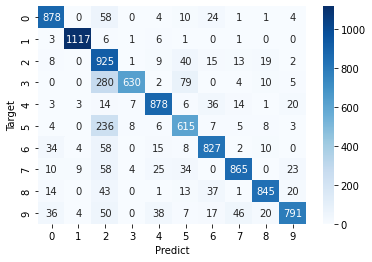

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.99      0.98      0.99      1135
           2       0.84      0.68      0.75      1032
           3       0.94      0.76      0.84      1010
           4       0.88      0.91      0.89       982
           5       0.60      0.91      0.73       892
           6       0.92      0.85      0.88       958
           7       0.95      0.80      0.87      1028
           8       0.90      0.87      0.88       974
           9       0.76      0.90      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



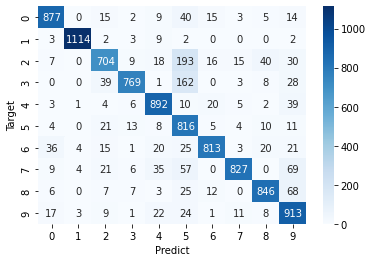

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       980
           1       0.98      0.98      0.98      1135
           2       0.70      0.81      0.75      1032
           3       0.95      0.74      0.83      1010
           4       0.91      0.89      0.90       982
           5       0.67      0.85      0.75       892
           6       0.89      0.85      0.87       958
           7       0.96      0.80      0.87      1028
           8       0.92      0.88      0.90       974
           9       0.83      0.88      0.85      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



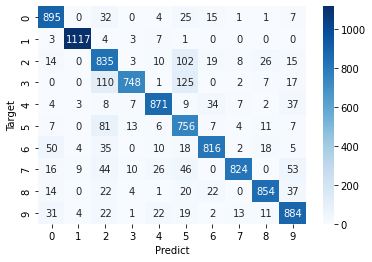

In [40]:
kfold_acc = []
for k in range(n_splits):
    evaluator_list[k].confusion_matrix(folder_name="confusion_matrix", fname=str(k), save=False)
    kfold_acc.append(evaluator_list[k].acc)

In [41]:
print("Acc mean: {:.4f}, std: {:.4f}".format(np.array(kfold_acc).mean(), np.array(kfold_acc).std()))

Acc mean: 0.8547, std: 0.0088


In [42]:
for k in range(n_splits):
    evaluator_list[k].show_scores(folder_name="eval", fname=str(k), save=False)

Accuracy: 0.8598
F scores: (0: 0.8865)(1: 0.9820)(2: 0.7586)(3: 0.8339)(4: 0.8930)(5: 0.7395)(6: 0.8743)(7: 0.8752)(8: 0.8958)(9: 0.8518)
Recalls: (0: 0.9204)(1: 0.9841)(2: 0.7461)(3: 0.7406)(4: 0.8880)(5: 0.8800)(6: 0.8570)(7: 0.8424)(8: 0.8778)(9: 0.8543)
Precisions: (0: 0.8550)(1: 0.9798)(2: 0.7715)(3: 0.9541)(4: 0.8980)(5: 0.6377)(6: 0.8924)(7: 0.9106)(8: 0.9144)(9: 0.8493)
Accuracy: 0.8593
F scores: (0: 0.9071)(1: 0.9833)(2: 0.7439)(3: 0.8275)(4: 0.8839)(5: 0.7523)(6: 0.8750)(7: 0.8774)(8: 0.8817)(9: 0.8594)
Recalls: (0: 0.8816)(1: 0.9850)(2: 0.8246)(3: 0.7337)(4: 0.9185)(5: 0.8274)(6: 0.8111)(7: 0.8142)(8: 0.9179)(9: 0.8632)
Precisions: (0: 0.9341)(1: 0.9816)(2: 0.6775)(3: 0.9488)(4: 0.8517)(5: 0.6897)(6: 0.9499)(7: 0.9511)(8: 0.8482)(9: 0.8556)
Accuracy: 0.8371
F scores: (0: 0.8914)(1: 0.9833)(2: 0.6703)(3: 0.7586)(4: 0.8932)(5: 0.7214)(6: 0.8610)(7: 0.8737)(8: 0.8951)(9: 0.8428)
Recalls: (0: 0.8959)(1: 0.9841)(2: 0.8963)(3: 0.6238)(4: 0.8941)(5: 0.6895)(6: 0.8633)(7: 0.8414)(8:

In [43]:
for k in range(n_splits):
    evaluator_list[k].show_cam(folder_name="cam", fname=str(k), save=False)

Classified as  1 , model output = tensor([0.0464, 0.9921, 0.0026, 0.0044, 0.5186, 0.0091, 0.1514, 0.7739, 0.0087,
        0.3414], device='cuda:0')
1 ( 1 ) 19.01 %
7 ( 7 ) 15.28 %
4 ( 4 ) 11.84 %
9 ( 9 ) 9.92 %
6 ( 6 ) 8.20 %
0 ( 0 ) 7.38 %
5 ( 5 ) 7.11 %
8 ( 8 ) 7.11 %
3 ( 3 ) 7.08 %
2 ( 2 ) 7.07 %


IndexError: ignored